# Import Library

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, Input, concatenate, Attention, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, activations
import gensim.downloader as api
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import tensorflow as tf
import time
import warnings

warnings.filterwarnings('ignore')

# Sentiment Analysis Workflow
Notebook ini mencakup:
- Preprocessing dan pelabelan otomatis dari data ulasan Play Store
- Pelatihan dan evaluasi model analisis sentimen
- Inference prediksi sentimen baru

In [37]:
# Unduh resource NLTK
nltk.download('stopwords')

# Load data
data = pd.read_csv('playstore_reviews_full.csv')
print(f"Jumlah data awal: {len(data)}")

# === CLEANING ===
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Stemming Setup
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()
stemmer_en = PorterStemmer()

stop_words_en = set(stopwords.words('english'))
stop_words_id = set([
    'yang', 'dan', 'di', 'dari', 'ke', 'pada', 'untuk', 'dengan', 'adalah',
    'ini', 'itu', 'atau', 'juga', 'saya', 'kamu', 'dia', 'mereka', 'kita',
    'kami', 'ada', 'tidak', 'akan', 'bisa', 'karena', 'jadi'
])
all_stop_words = stop_words_en.union(stop_words_id)

def stem_text(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stop_words]
        stemmed_words = [stemmer_id.stem(word) for word in filtered_words]
        return ' '.join(stemmed_words)
    return ""

def label_by_rating(score):
    try:
        score = float(score)
        if score <= 2:
            return 'negative'
        elif score == 3:
            return 'neutral'
        else:
            return 'positive'
    except:
        return None

# === APPLY CLEANING ===
print("Cleaning...")
data['cleaned_text'] = data['content'].apply(clean_text)

# === APPLY STEMMING WITH PARALLEL ===
print("Stemming with parallel processing...")
data['processed_text'] = Parallel(n_jobs=-1)(
    delayed(stem_text)(text) for text in data['cleaned_text']
)

# === LABELING ===
print("Melakukan pelabelan...")
data['sentiment_label'] = data['score'].apply(label_by_rating)
data = data.dropna(subset=['sentiment_label'])

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
data['sentiment_score'] = data['sentiment_label'].map(label_map)

# === PENANGANAN DATA TIDAK SEIMBANG DENGAN SMOTE ===
print("Memeriksa distribusi kelas...")
class_distribution = data['sentiment_score'].value_counts()
print("Distribusi kelas sebelum balancing:")
print(class_distribution)

print("Menangani ketidakseimbangan data dengan SMOTE...")

# Menyiapkan data
X = data['processed_text']
y = data['sentiment_score']

# Mengubah data teks menjadi fitur numerik menggunakan TF-IDF
print("Mengkonversi teks ke fitur TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Menerapkan SMOTE
print("Menerapkan SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

print(f"Bentuk asli: {X_tfidf.shape}, Bentuk setelah resampling: {X_resampled.shape}")
print("Distribusi kelas setelah SMOTE:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

# Membuat dataset yang seimbang
print("Membuat dataset yang seimbang...")

# Menyimpan indeks asli untuk setiap kelas
original_indices = {}
for class_val in np.unique(y):
    original_indices[class_val] = np.where(y == class_val)[0]

# Membuat dataset seimbang dengan memilih sampel asli untuk setiap kelas
balanced_data = pd.DataFrame()

for class_val in np.unique(y_resampled):
    # Menghitung berapa banyak sampel yang dibutuhkan untuk kelas ini
    class_count = sum(y_resampled == class_val)
    
    # Mendapatkan sampel asli untuk kelas ini
    class_samples = data[data['sentiment_score'] == class_val]
    
    # Jika kita butuh lebih banyak sampel daripada yang kita miliki, lakukan oversampling dengan penggantian
    if len(class_samples) < class_count:
        class_samples = class_samples.sample(n=class_count, replace=True, random_state=42)
    # Jika kita punya lebih banyak dari yang dibutuhkan, lakukan undersampling tanpa penggantian
    else:
        class_samples = class_samples.sample(n=class_count, replace=False, random_state=42)
    
    balanced_data = pd.concat([balanced_data, class_samples])

# Acak data yang seimbang
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Periksa distribusi baru
print("Distribusi kelas dalam dataset yang telah diseimbangkan:")
print(balanced_data['sentiment_score'].value_counts())

# Ganti data lama dengan data yang telah diseimbangkan
data = balanced_data

# === SIMPAN HASIL ===
data.to_csv('processed_sentiment_dataset.csv', index=False)
print(f"Disimpan ke 'processed_sentiment_dataset.csv'")
print(f"Jumlah data awal: {len(data)}, Jumlah data setelah balancing: {len(balanced_data)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Jumlah data awal: 3000
Cleaning...
Stemming with parallel processing...
Melakukan pelabelan...
Memeriksa distribusi kelas...
Distribusi kelas sebelum balancing:
sentiment_score
2    1858
0     979
1     163
Name: count, dtype: int64
Menangani ketidakseimbangan data dengan SMOTE...
Mengkonversi teks ke fitur TF-IDF...
Menerapkan SMOTE...
Bentuk asli: (3000, 1000), Bentuk setelah resampling: (5574, 1000)
Distribusi kelas setelah SMOTE:
{0: 1858, 1: 1858, 2: 1858}
Membuat dataset yang seimbang...
Distribusi kelas dalam dataset yang telah diseimbangkan:
sentiment_score
1    1858
0    1858
2    1858
Name: count, dtype: int64
Disimpan ke 'processed_sentiment_dataset.csv'
Jumlah data awal: 5574, Jumlah data setelah balancing: 5574


# Analisis Sentimen - Training Model

### Menyiapkan Data

In [38]:
# Unduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('punkt_tab')

# Muat dataset yang telah diproses
print("Memuat dataset...")
data = pd.read_csv('processed_sentiment_dataset.csv')
print(f"Dataset dimuat dengan {len(data)} baris")

# Periksa distribusi label sentimen
print("\nDistribusi label sentimen:")
print(data['sentiment_label'].value_counts())
print(data['sentiment_label'].value_counts(normalize=True) * 100)

# Gambaran data
print("\nContoh Data:")
print(data[['app_name', 'processed_text', 'sentiment_label']].head())

# Periksa nilai yang hilang
nilai_hilang = data.isnull().sum()
print("\nNilai yang hilang:")
print(nilai_hilang[nilai_hilang > 0])

# Hapus nilai yang hilang yang tersisa
data = data.dropna(subset=['processed_text', 'sentiment_label'])
print(f"Dataset setelah menghapus nilai yang hilang: {len(data)} baris")

# Ubah variabel target menjadi numerik
peta_label = {'negative': 0, 'neutral': 1, 'positive': 2}
data['sentiment_score'] = data['sentiment_label'].map(peta_label)

# Buat variabel fitur dan target
X = data['processed_text']
y = data['sentiment_score']

# Bagi data - Kita akan mencoba pembagian yang berbeda sesuai pedoman pengajuan
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Pembagian 80/20 - Set pelatihan: {len(X_train_80)}, Set pengujian: {len(X_test_20)}")
print(f"Pembagian 70/30 - Set pelatihan: {len(X_train_70)}, Set pengujian: {len(X_test_30)}")

# Tentukan fungsi untuk mengevaluasi dan menampilkan kinerja model
def evaluasi_model(y_true, y_pred, nama_model):
    akurasi = accuracy_score(y_true, y_pred)
    print(f"Akurasi {nama_model}: {akurasi * 100:.2f}%")
    
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_true, y_pred, target_names=list(peta_label.keys())))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(peta_label.keys()), 
                yticklabels=list(peta_label.keys()))
    plt.xlabel('Diprediksi')
    plt.ylabel('Sebenarnya')
    plt.title(f'Confusion Matrix - {nama_model}')
    plt.tight_layout()
    plt.show()
    
    return akurasi

# Simpan hasil untuk perbandingan
hasil = []

Memuat dataset...
Dataset dimuat dengan 5574 baris

Distribusi label sentimen:
sentiment_label
neutral     1858
negative    1858
positive    1858
Name: count, dtype: int64
sentiment_label
neutral     33.333333
negative    33.333333
positive    33.333333
Name: proportion, dtype: float64

Contoh Data:
    app_name                                     processed_text  \
0     Shopee  mengapa tiap buka aplikasi selalu lot padahal ...   
1    Netflix   gue kasih dulu kalu bagus aplikasi gue tambah ok   
2     Jenius         sangat rekomendasi sistem nya sangat buruk   
3  Instagram  bgs sih tpi sayang nya akun ku g komen sg stor...   
4  Instagram  fitur baru banyak problem banyak teruk betul b...   

  sentiment_label  
0         neutral  
1         neutral  
2        negative  
3         neutral  
4        negative  

Nilai yang hilang:
cleaned_text      34
processed_text    46
dtype: int64
Dataset setelah menghapus nilai yang hilang: 5528 baris
Pembagian 80/20 - Set pelatihan: 4422, Set pe

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### EKSPERIMEN 1: TF-IDF + SVM dengan pembagian 80/20


EKSPERIMEN 1: TF-IDF + SVM dengan pembagian 80/20
Waktu pelatihan: 0.17 detik

Evaluasi set pelatihan:
Akurasi TF-IDF + SVM (Pelatihan): 97.83%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.99      0.98      0.99      1480
     neutral       0.98      0.97      0.98      1477
    positive       0.96      0.98      0.97      1465

    accuracy                           0.98      4422
   macro avg       0.98      0.98      0.98      4422
weighted avg       0.98      0.98      0.98      4422



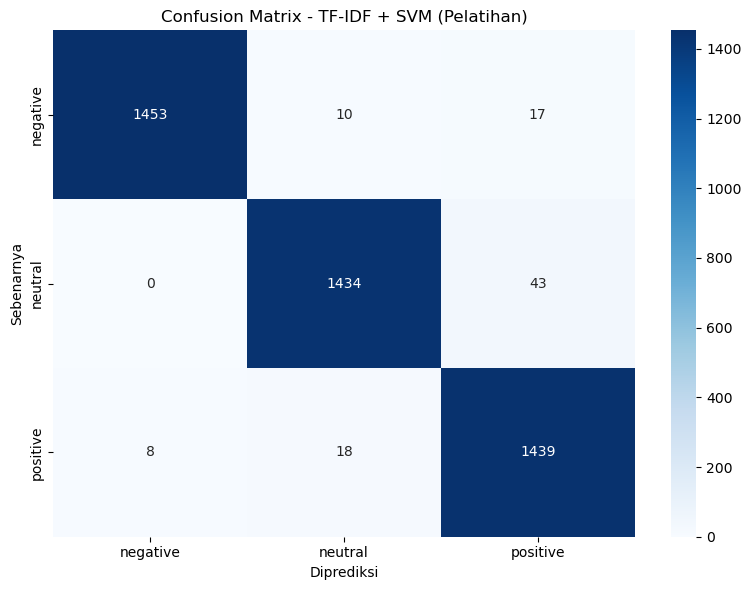


Evaluasi set pengujian:
Akurasi TF-IDF + SVM (Pengujian): 92.77%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.90      0.95      0.93       370
     neutral       0.97      0.96      0.97       370
    positive       0.91      0.87      0.89       366

    accuracy                           0.93      1106
   macro avg       0.93      0.93      0.93      1106
weighted avg       0.93      0.93      0.93      1106



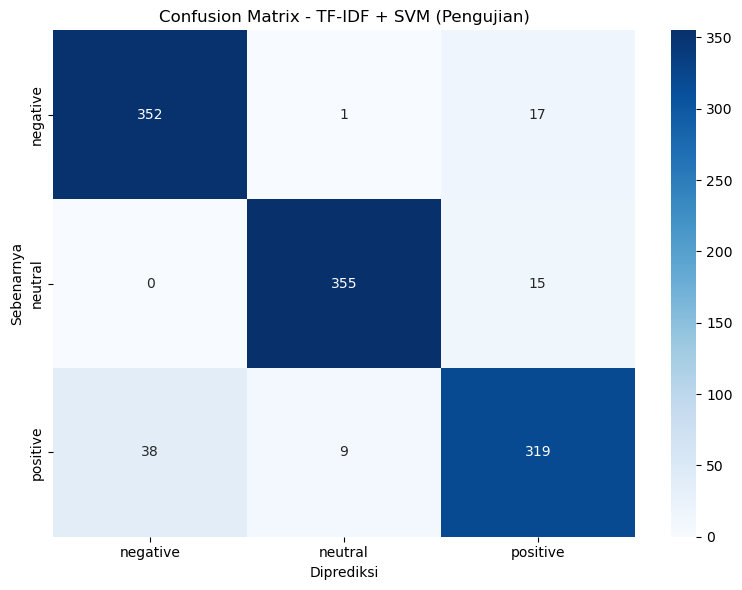

Model disimpan sebagai 'tfidf_svm_80_20_model.joblib'


In [39]:
print("\n" + "="*50)
print("EKSPERIMEN 1: TF-IDF + SVM dengan pembagian 80/20")
print("="*50)

# Buat pipeline
tfidf_svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svm', LinearSVC(C=1.0))
])

# Latih model
waktu_mulai = time.time()
tfidf_svm_pipeline.fit(X_train_80, y_train_80)
waktu_pelatihan = time.time() - waktu_mulai
print(f"Waktu pelatihan: {waktu_pelatihan:.2f} detik")

# Prediksi pada set pelatihan dan pengujian
y_train_pred = tfidf_svm_pipeline.predict(X_train_80)
y_test_pred = tfidf_svm_pipeline.predict(X_test_20)

# Evaluasi model
print("\nEvaluasi set pelatihan:")
akurasi_train = evaluasi_model(y_train_80, y_train_pred, "TF-IDF + SVM (Pelatihan)")

print("\nEvaluasi set pengujian:")
akurasi_test = evaluasi_model(y_test_20, y_test_pred, "TF-IDF + SVM (Pengujian)")

# Simpan hasil
hasil.append({
    'eksperimen': 'TF-IDF + SVM (80/20)',
    'ekstraksi_fitur': 'TF-IDF',
    'model': 'SVM',
    'pembagian': '80/20',
    'akurasi_train': akurasi_train,
    'akurasi_test': akurasi_test,
    'waktu_pelatihan': waktu_pelatihan
})

# Simpan model
joblib.dump(tfidf_svm_pipeline, 'tfidf_svm_80_20_model.joblib')
print("Model disimpan sebagai 'tfidf_svm_80_20_model.joblib'")

### EKSPERIMEN 2: Word2Vec + Random Forest dengan pembagian 80/20


EKSPERIMEN 2: Word2Vec + Random Forest dengan pembagian 80/20
Memuat model Word2Vec...
Model Word2Vec dimuat
Membuat vektor dokumen...
Vektor dokumen telah dibuat
Waktu pelatihan: 3.89 detik

Evaluasi set pelatihan:
Akurasi Word2Vec + RF (Pelatihan): 91.59%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.99      0.91      0.95      1480
     neutral       0.95      0.87      0.91      1477
    positive       0.83      0.97      0.89      1465

    accuracy                           0.92      4422
   macro avg       0.92      0.92      0.92      4422
weighted avg       0.92      0.92      0.92      4422



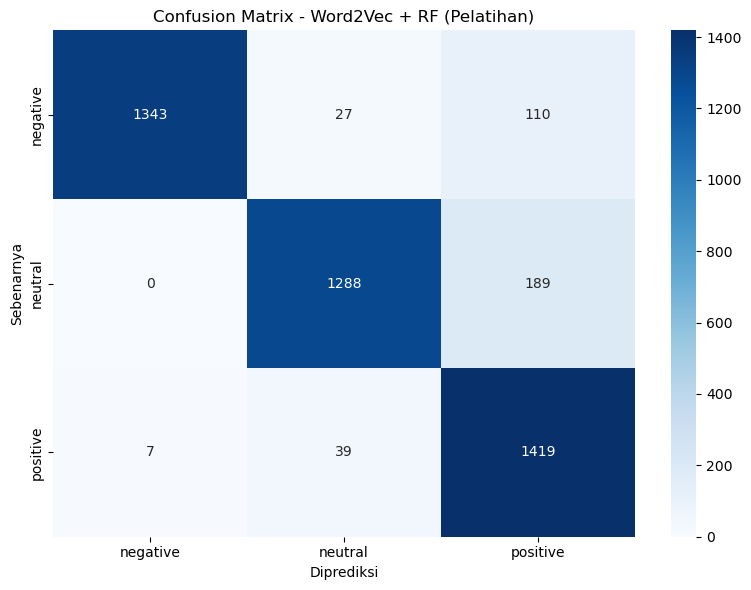


Evaluasi set pengujian:
Akurasi Word2Vec + RF (Pengujian): 86.80%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.84      0.92      0.88       370
     neutral       0.96      0.88      0.92       370
    positive       0.81      0.80      0.80       366

    accuracy                           0.87      1106
   macro avg       0.87      0.87      0.87      1106
weighted avg       0.87      0.87      0.87      1106



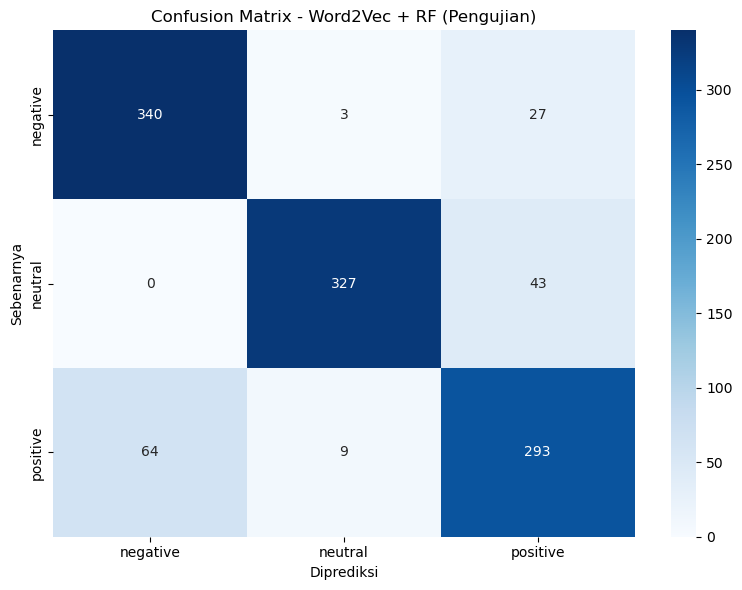

Model disimpan sebagai 'w2v_rf_80_20_model.joblib'
Fungsi vektor dokumen disimpan sebagai 'fungsi_vektor_dokumen_w2v.pkl'


In [40]:
print("\n" + "="*50)
print("EKSPERIMEN 2: Word2Vec + Random Forest dengan pembagian 80/20")
print("="*50)

# Muat model Word2Vec yang sudah dilatih sebelumnya
print("Memuat model Word2Vec...")
word2vec_model = api.load('word2vec-google-news-300')
print("Model Word2Vec dimuat")

# Fungsi untuk membuat vektor dokumen dari Word2Vec
def vektor_dokumen(doc, model, ukuran_vektor=300):
    # Inisialisasi vektor nol
    vektor_doc = np.zeros(ukuran_vektor)
    jumlah_kata = 0
    
    # Tokenisasi dokumen
    if isinstance(doc, str):
        kata_kata = word_tokenize(doc.lower())
        
        # Jumlahkan vektor untuk semua kata dalam dokumen
        for kata in kata_kata:
            try:
                # Tambahkan vektor kata jika ada dalam model
                vektor_doc += model[kata]
                jumlah_kata += 1
            except KeyError:
                # Lewati kata yang tidak ada dalam kosakata
                continue
                
        # Hitung vektor rata-rata jika ada kata yang ditemukan
        if jumlah_kata > 0:
            vektor_doc /= jumlah_kata
            
    return vektor_doc

# Buat vektor dokumen untuk set pelatihan dan pengujian
print("Membuat vektor dokumen...")
X_train_w2v = np.array([vektor_dokumen(doc, word2vec_model) for doc in X_train_80])
X_test_w2v = np.array([vektor_dokumen(doc, word2vec_model) for doc in X_test_20])
print("Vektor dokumen telah dibuat")

# Latih Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

waktu_mulai = time.time()
model_rf.fit(X_train_w2v, y_train_80)
waktu_pelatihan = time.time() - waktu_mulai
print(f"Waktu pelatihan: {waktu_pelatihan:.2f} detik")

# Prediksi pada set pelatihan dan pengujian
y_train_pred = model_rf.predict(X_train_w2v)
y_test_pred = model_rf.predict(X_test_w2v)

# Evaluasi model
print("\nEvaluasi set pelatihan:")
akurasi_train = evaluasi_model(y_train_80, y_train_pred, "Word2Vec + RF (Pelatihan)")

print("\nEvaluasi set pengujian:")
akurasi_test = evaluasi_model(y_test_20, y_test_pred, "Word2Vec + RF (Pengujian)")

# Simpan hasil
hasil.append({
    'eksperimen': 'Word2Vec + RF (80/20)',
    'ekstraksi_fitur': 'Word2Vec',
    'model': 'Random Forest',
    'pembagian': '80/20',
    'akurasi_train': akurasi_train,
    'akurasi_test': akurasi_test,
    'waktu_pelatihan': waktu_pelatihan
})

# Simpan model dan vektorisasi
joblib.dump(model_rf, 'w2v_rf_80_20_model.joblib')
print("Model disimpan sebagai 'w2v_rf_80_20_model.joblib'")

# Simpan juga fungsi vektor dokumen untuk inferensi
with open('fungsi_vektor_dokumen_w2v.pkl', 'wb') as f:
    pickle.dump(vektor_dokumen, f)
print("Fungsi vektor dokumen disimpan sebagai 'fungsi_vektor_dokumen_w2v.pkl'")

### EKSPERIMEN 3: TF-IDF + Random Forest dengan pembagian 70/30


EKSPERIMEN 3: TF-IDF + Random Forest dengan pembagian 70/30
Waktu pelatihan: 4.01 detik

Evaluasi set pelatihan:
Akurasi TF-IDF + RF (Pelatihan): 98.16%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       1.00      0.99      0.99      1295
     neutral       0.99      0.97      0.98      1293
    positive       0.96      0.99      0.97      1281

    accuracy                           0.98      3869
   macro avg       0.98      0.98      0.98      3869
weighted avg       0.98      0.98      0.98      3869



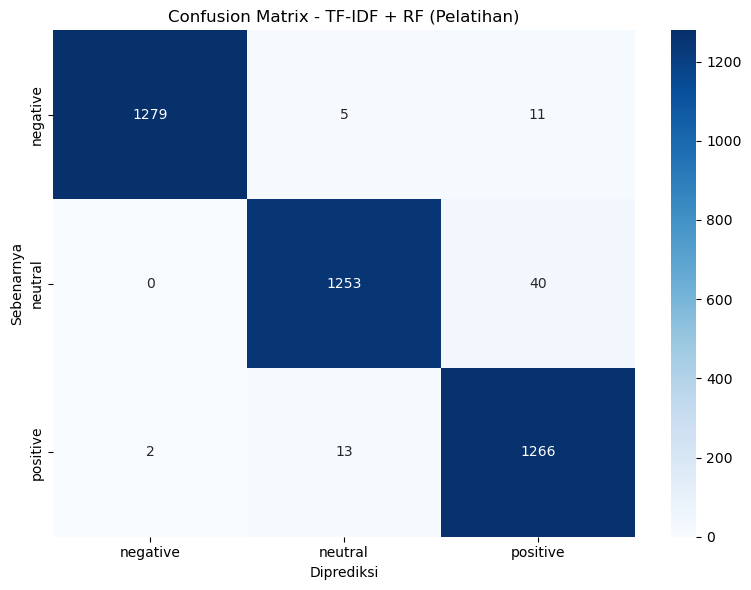


Evaluasi set pengujian:
Akurasi TF-IDF + RF (Pengujian): 93.13%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.91      0.94      0.92       555
     neutral       0.98      0.97      0.97       554
    positive       0.91      0.89      0.90       550

    accuracy                           0.93      1659
   macro avg       0.93      0.93      0.93      1659
weighted avg       0.93      0.93      0.93      1659



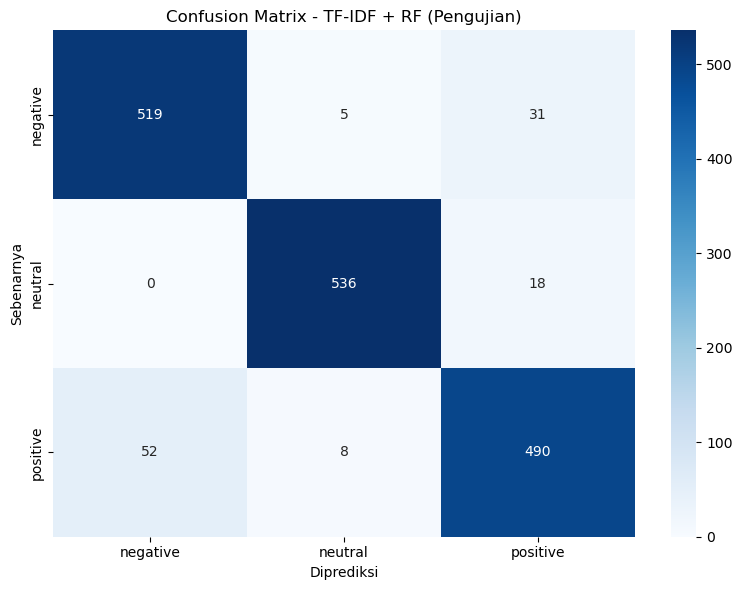

Model disimpan sebagai 'tfidf_rf_70_30_model.joblib'
Vektorisasi disimpan sebagai 'tfidf_vectorizer_70_30.joblib'


In [41]:
print("\n" + "="*50)
print("EKSPERIMEN 3: TF-IDF + Random Forest dengan pembagian 70/30")
print("="*50)

# Buat fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_70)
X_test_tfidf = tfidf_vectorizer.transform(X_test_30)

# Latih Random Forest
model_rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

waktu_mulai = time.time()
model_rf_tfidf.fit(X_train_tfidf, y_train_70)
waktu_pelatihan = time.time() - waktu_mulai
print(f"Waktu pelatihan: {waktu_pelatihan:.2f} detik")

# Prediksi pada set pelatihan dan pengujian
y_train_pred = model_rf_tfidf.predict(X_train_tfidf)
y_test_pred = model_rf_tfidf.predict(X_test_tfidf)

# Evaluasi model
print("\nEvaluasi set pelatihan:")
akurasi_train = evaluasi_model(y_train_70, y_train_pred, "TF-IDF + RF (Pelatihan)")

print("\nEvaluasi set pengujian:")
akurasi_test = evaluasi_model(y_test_30, y_test_pred, "TF-IDF + RF (Pengujian)")

# Simpan hasil
hasil.append({
    'eksperimen': 'TF-IDF + RF (70/30)',
    'ekstraksi_fitur': 'TF-IDF',
    'model': 'Random Forest',
    'pembagian': '70/30',
    'akurasi_train': akurasi_train,
    'akurasi_test': akurasi_test,
    'waktu_pelatihan': waktu_pelatihan
})

# Simpan model dan vektorisasi
joblib.dump(model_rf_tfidf, 'tfidf_rf_70_30_model.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_70_30.joblib')
print("Model disimpan sebagai 'tfidf_rf_70_30_model.joblib'")
print("Vektorisasi disimpan sebagai 'tfidf_vectorizer_70_30.joblib'")

### EKSPERIMEN 4: Deep Learning - LSTM dengan pembagian 80/20

In [ ]:
print("\n" + "="*50)
print("EKSPERIMEN 4: Deep Learning - LSTM dengan pembagian 80/20")
print("="*50)

# Tokenisasi teks
max_features = 10000  # Kata teratas yang dipertimbangkan
max_len = 100  # Panjang urutan maksimum

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_80)

X_train_seq = tokenizer.texts_to_sequences(X_train_80)
X_test_seq = tokenizer.texts_to_sequences(X_test_20)

# Pad urutan
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Ubah target menjadi kategorikal
y_train_cat = to_categorical(y_train_80, num_classes=3)
y_test_cat = to_categorical(y_test_20, num_classes=3)

# Buat model LSTM menggunakan Functional API
inputs = tf.keras.Input(shape=(max_len,))
x = Embedding(max_features, 300, input_length=max_len)(inputs)
x = SpatialDropout1D(0.25)(x)
x = Bidirectional(LSTM(150, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(x)

# Add Attention layer with proper inputs
attention_output = Attention()([x, x])  # Pass query and value to the Attention layer

# Add a pooling layer to reduce the sequence dimension
x = GlobalAveragePooling1D()(attention_output)

x = Dense(128, activation='relu')(attention_output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

# Define the model
model_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)

# Kompilasi model dengan learning rate yang disesuaikan
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build model sebelum summary
model_lstm.build((None, max_len))
model_lstm.summary()

# Penghentian dini tetap sama
penghentian_dini = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Tambahkan callback untuk mengurangi learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Latih model dengan batch size yang lebih kecil
waktu_mulai = time.time()
history = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15,  # Lebih banyak epoch
    batch_size=32,  # Batch size lebih kecil
    validation_split=0.1,
    callbacks=[penghentian_dini, reduce_lr],
    verbose=1
)
waktu_pelatihan = time.time() - waktu_mulai
print(f"Waktu pelatihan: {waktu_pelatihan:.2f} detik")

# Plot riwayat pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Pelatihan', 'Validasi'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Pelatihan', 'Validasi'], loc='upper left')
plt.tight_layout()
plt.show()

# Evaluasi pada set pelatihan
y_train_prob = model_lstm.predict(X_train_pad)
y_train_pred = np.argmax(y_train_prob, axis=1)

# Evaluasi pada set pengujian
y_test_prob = model_lstm.predict(X_test_pad)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Ubah kembali dari kategorikal
y_train_true = np.array(y_train_80)
y_test_true = np.array(y_test_20)

# Evaluasi model
print("\nEvaluasi set pelatihan:")
akurasi_train = evaluasi_model(y_train_true, y_train_pred, "LSTM (Pelatihan)")

print("\nEvaluasi set pengujian:")
akurasi_test = evaluasi_model(y_test_true, y_test_pred, "LSTM (Pengujian)")

# Simpan hasil
hasil.append({
    'eksperimen': 'LSTM (80/20)',
    'ekstraksi_fitur': 'Word Embeddings',
    'model': 'Bidirectional LSTM',
    'pembagian': '80/20',
    'akurasi_train': akurasi_train,
    'akurasi_test': akurasi_test,
    'waktu_pelatihan': waktu_pelatihan
})

# Simpan model dan tokenizer
model_lstm.save('lstm_80_20_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Model disimpan sebagai 'lstm_80_20_model.h5'")
print("Tokenizer disimpan sebagai 'tokenizer.pickle'")


EKSPERIMEN 4: Deep Learning - LSTM dengan pembagian 80/20


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 100, 300)  │  3,000,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_9 │ (None, 100, 300)  │          0 │ embedding_9[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 100, 300)  │    541,200 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 100, 300)  │          0 │ bidirectional_8[… │
│ (Attention)         │                   │            │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 100, 128)  │     38,528 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 100, 64)   │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 100, 3)    │        195 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,588,947 (13.69 MB)

 Trainable params: 3,588,563 (13.69 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3), output.shape=(None, 100, 3)

### EKSPERIMEN 5: Deep Learning - CNN dengan pembagian 80/20


EKSPERIMEN 5: Deep Learning - CNN dengan pembagian 80/20


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 100, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 128)       │        76,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,242,051 (8.55 MB)

 Trainable params: 2,241,795 (8.55 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.7651 - loss: 0.8168 - val_accuracy: 0.6638 - val_loss: 0.7968 - learning_rate: 5.0000e-04
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.8719 - loss: 0.4619 - val_accuracy: 0.8226 - val_loss: 0.5895 - learning_rate: 5.0000e-04
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.9135 - loss: 0.3259 - val_accuracy: 0.8387 - val_loss: 0.5144 - learning_rate: 5.0000e-04
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.9506 - loss: 0.2131 - val_accuracy: 0.7097 - val_loss: 1.0817 - learning_rate: 5.0000e-04
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.9680 - loss: 0.1512 - val_accuracy: 0.8015 - val_loss: 0.6658 - learning_rate: 5.0000e-04
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.9812 - loss: 0.1154 - val_accuracy: 0.8350 - val_loss: 0.6754 - learning_rate: 2.5000e-04
Waktu pelatihan: 205.33 detik


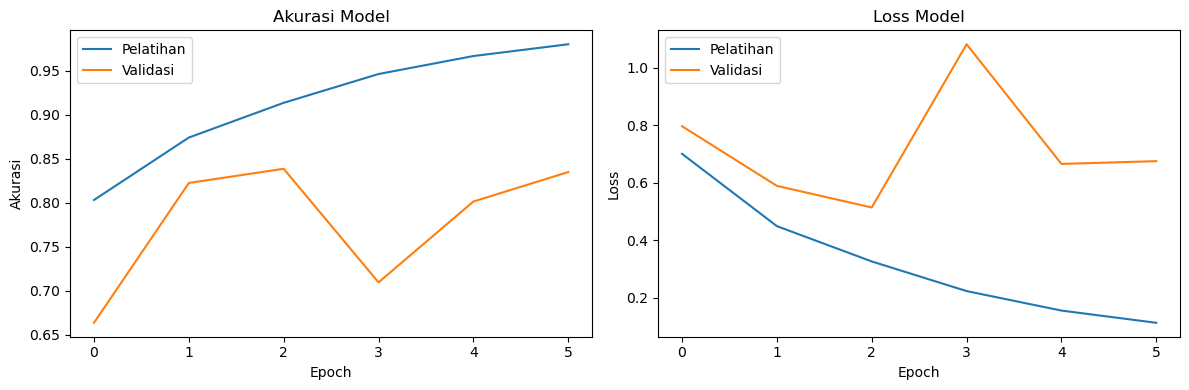

252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

Evaluasi set pelatihan:
Akurasi CNN (Pelatihan): 95.52%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.96      0.95      0.96      2898
     neutral       0.92      0.56      0.69       395
    positive       0.95      0.99      0.97      4761

    accuracy                           0.96      8054
   macro avg       0.95      0.83      0.87      8054
weighted avg       0.95      0.96      0.95      8054



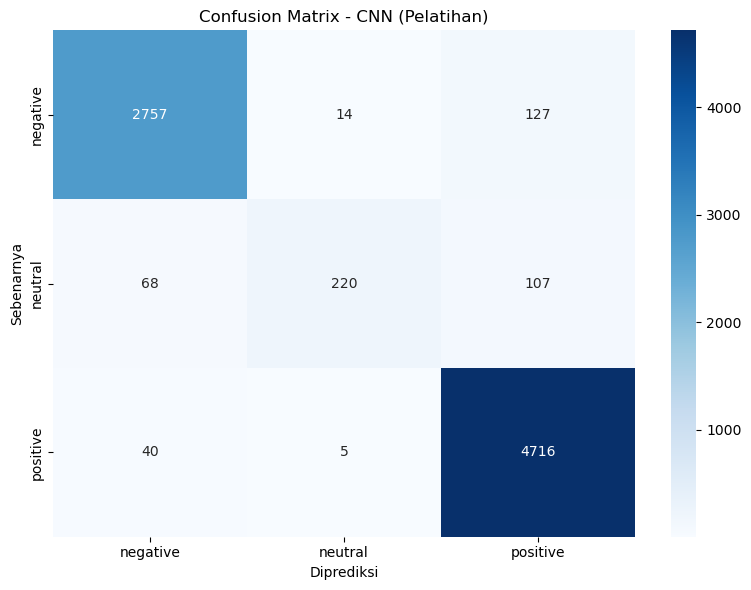


Evaluasi set pengujian:
Akurasi CNN (Pengujian): 81.83%

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78       725
     neutral       0.13      0.04      0.06        98
    positive       0.85      0.91      0.88      1191

    accuracy                           0.82      2014
   macro avg       0.59      0.57      0.57      2014
weighted avg       0.79      0.82      0.80      2014



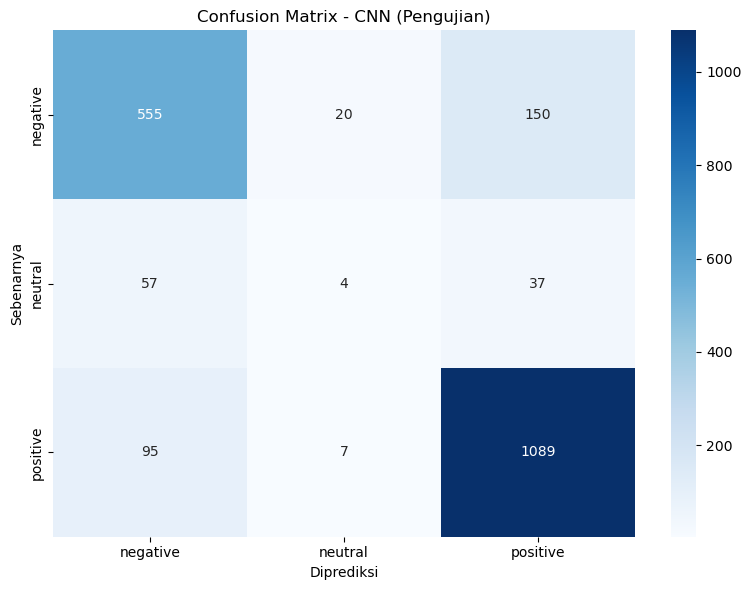

Model disimpan sebagai 'cnn_80_20_model.h5'


In [ ]:
print("\n" + "="*50)
print("EKSPERIMEN 5: Deep Learning - CNN dengan pembagian 80/20")
print("="*50)

# Buat model CNN menggunakan Functional API
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(max_features, 300, input_length=max_len)(input_layer)
embedding_layer = SpatialDropout1D(0.25)(embedding_layer)

# Multiple parallel convolutions
filter_sizes = [2, 3, 4, 5]
conv_blocks = []

for sz in filter_sizes:
    conv = Conv1D(filters=256, kernel_size=sz, padding='valid', activation='relu', strides=1)(embedding_layer)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

merged = concatenate(conv_blocks, axis=1)
dense = Dense(256, activation='relu')(merged)
dense = BatchNormalization()(dense)
dense = Dropout(0.4)(dense)
dense = Dense(128, activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(dense)

# Membuat model
model_cnn = Model(inputs=input_layer, outputs=output)

# Kompilasi model dengan learning rate yang dioptimalkan
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summary dari model
model_cnn.summary()

penghentian_dini = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Callback untuk mengurangi learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Latih model
waktu_mulai = time.time()
history = model_cnn.fit(
    X_train_pad, y_train_cat,
    epochs=15,  # Lebih banyak epoch
    batch_size=32,  # Batch size lebih kecil
    validation_split=0.1,
    callbacks=[penghentian_dini, reduce_lr],
    verbose=1
)
waktu_pelatihan = time.time() - waktu_mulai
print(f"Waktu pelatihan: {waktu_pelatihan:.2f} detik")

# RINGKASAN DAN PERBANDINGAN


RINGKASAN PERBANDINGAN MODEL
              eksperimen  ekstraksi_fitur               model pembagian  \
0   TF-IDF + SVM (80/20)           TF-IDF                 SVM     80/20   
1  Word2Vec + RF (80/20)         Word2Vec       Random Forest     80/20   
2    TF-IDF + RF (70/30)           TF-IDF       Random Forest     70/30   
3           LSTM (80/20)  Word Embeddings  Bidirectional LSTM     80/20   
4            CNN (80/20)  Word Embeddings                 CNN     80/20   

   akurasi_train  akurasi_test  waktu_pelatihan  
0       0.969829      0.832175         0.638971  
1       0.946486      0.765144        22.637391  
2       0.984532      0.836809        16.758595  
3       0.890862      0.820755      2821.023146  
4       0.955178      0.818272       205.327961  

Model diurutkan berdasarkan akurasi pengujian:
              eksperimen  ekstraksi_fitur               model pembagian  \
2    TF-IDF + RF (70/30)           TF-IDF       Random Forest     70/30   
0   TF-IDF + SVM (80/

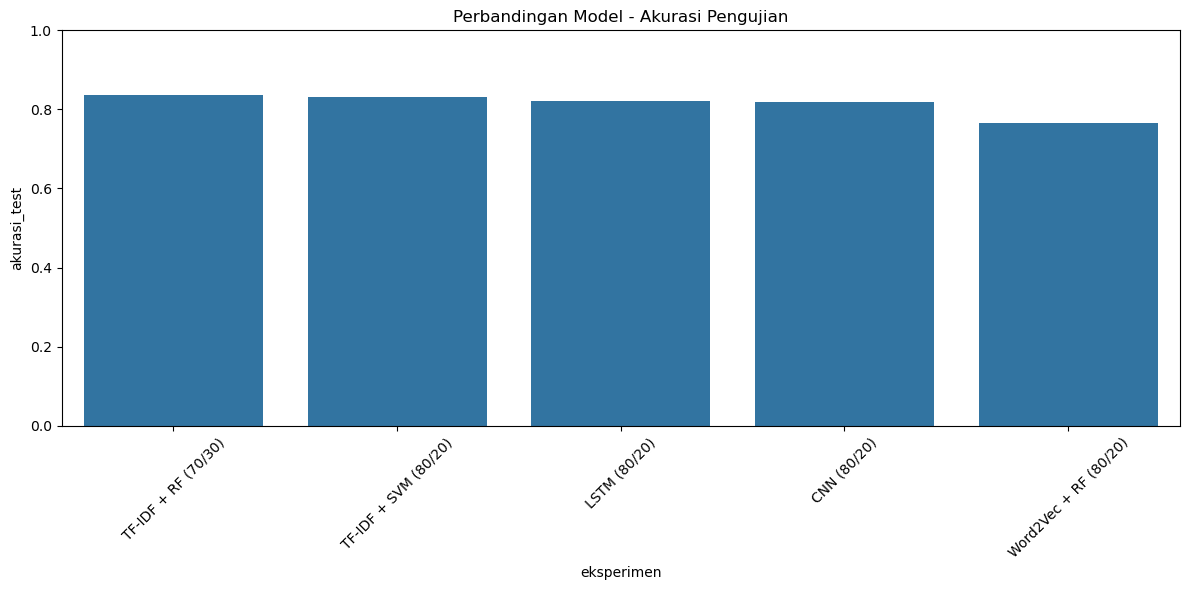

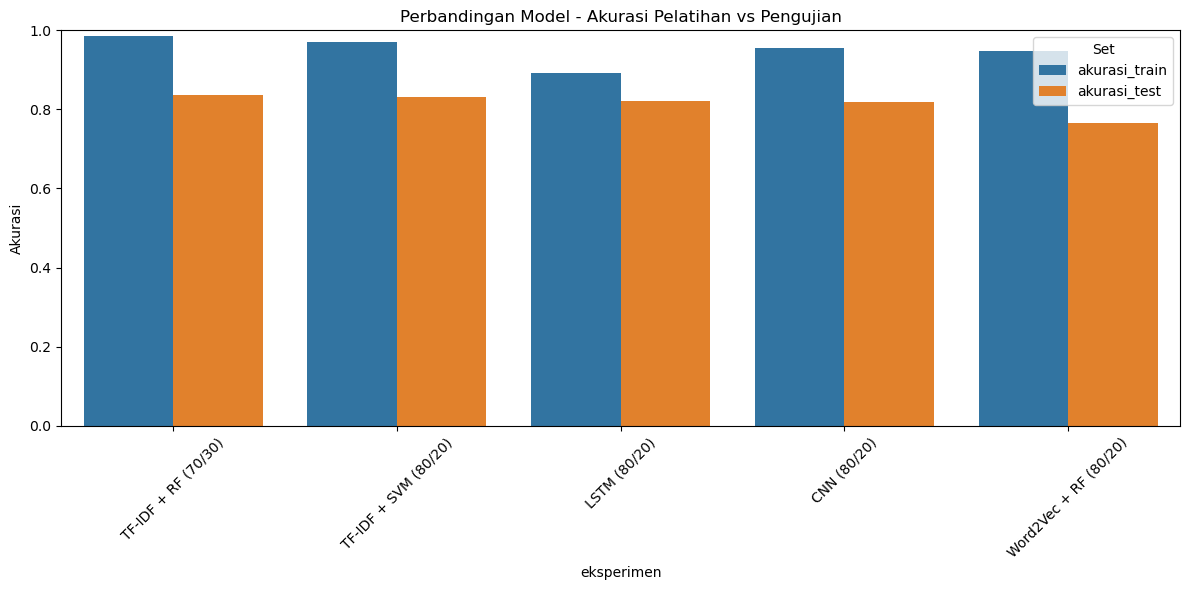


Model Terbaik Berdasarkan Akurasi Pengujian:
Eksperimen: TF-IDF + RF (70/30)
Ekstraksi Fitur: TF-IDF
Model: Random Forest
Pembagian: 70/30
Akurasi Pelatihan: 98.45%
Akurasi Pengujian: 83.68%
Waktu Pelatihan: 16.76 detik


In [ ]:
print("\n" + "="*50)
print("RINGKASAN PERBANDINGAN MODEL")
print("="*50)

# Buat DataFrame untuk perbandingan
df_hasil = pd.DataFrame(hasil)
print(df_hasil)

# Urutkan berdasarkan akurasi pengujian
df_hasil_diurutkan = df_hasil.sort_values('akurasi_test', ascending=False)
print("\nModel diurutkan berdasarkan akurasi pengujian:")
print(df_hasil_diurutkan)

# Plot perbandingan model
plt.figure(figsize=(12, 6))
sns.barplot(x='eksperimen', y='akurasi_test', data=df_hasil_diurutkan)
plt.title('Perbandingan Model - Akurasi Pengujian')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot akurasi pelatihan vs pengujian
plt.figure(figsize=(12, 6))
df_hasil_meleleh = pd.melt(df_hasil_diurutkan, 
                            id_vars=['eksperimen'], 
                            value_vars=['akurasi_train', 'akurasi_test'],
                            var_name='Set', value_name='Akurasi')
sns.barplot(x='eksperimen', y='Akurasi', hue='Set', data=df_hasil_meleleh)
plt.title('Perbandingan Model - Akurasi Pelatihan vs Pengujian')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Identifikasi model terbaik
model_terbaik = df_hasil_diurutkan.iloc[0]
print("\nModel Terbaik Berdasarkan Akurasi Pengujian:")
print(f"Eksperimen: {model_terbaik['eksperimen']}")
print(f"Ekstraksi Fitur: {model_terbaik['ekstraksi_fitur']}")
print(f"Model: {model_terbaik['model']}")
print(f"Pembagian: {model_terbaik['pembagian']}")
print(f"Akurasi Pelatihan: {model_terbaik['akurasi_train'] * 100:.2f}%")
print(f"Akurasi Pengujian: {model_terbaik['akurasi_test'] * 100:.2f}%")
print(f"Waktu Pelatihan: {model_terbaik['waktu_pelatihan']:.2f} detik")

# CONTOH INFERENSI

In [ ]:
print("\n" + "="*50)
print("CONTOH INFERENSI")
print("="*50)

# Fungsi untuk melakukan inferensi dengan model terbaik
def prediksi_sentimen(teks, jenis_model='terbaik'):
    # Praproses teks (disederhanakan untuk demonstrasi)
    teks_diproses = teks.lower()
    
    # Pilih model berdasarkan jenis
    if jenis_model == 'tfidf_svm':
        # Muat model TF-IDF + SVM
        model = joblib.load('tfidf_svm_80_20_model.joblib')
        prediksi = model.predict([teks_diproses])[0]
    
    elif jenis_model == 'word2vec_rf':
        # Muat model Word2Vec + RF
        model = joblib.load('w2v_rf_80_20_model.joblib')
        with open('fungsi_vektor_dokumen_w2v.pkl', 'rb') as f:
            fungsi_vektor_doc = pickle.load(f)
        
        # Buat vektor dokumen
        vektor_doc = fungsi_vektor_doc(teks_diproses, word2vec_model)
        prediksi = model.predict([vektor_doc])[0]
    
    elif jenis_model == 'lstm':
        # Muat model LSTM
        model = tf.keras.models.load_model('lstm_80_20_model.h5')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        
        # Tokenisasi dan pad
        seq = tokenizer.texts_to_sequences([teks_diproses])
        padded = pad_sequences(seq, maxlen=max_len)
        
        # Prediksi
        pred_prob = model.predict(padded)[0]
        prediksi = np.argmax(pred_prob)
    
    elif jenis_model == 'cnn':
        # Muat model CNN
        model = tf.keras.models.load_model('cnn_80_20_model.h5')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        
        # Tokenisasi dan pad
        seq = tokenizer.texts_to_sequences([teks_diproses])
        padded = pad_sequences(seq, maxlen=max_len)
        
        # Prediksi
        pred_prob = model.predict(padded)[0]
        prediksi = np.argmax(pred_prob)
    
    else:  # model terbaik (tentukan dari hasil)
        # Gunakan model terbaik berdasarkan hasil
        if model_terbaik['eksperimen'] == 'LSTM (80/20)':
            return prediksi_sentimen(teks, 'lstm')
        elif model_terbaik['eksperimen'] == 'CNN (80/20)':
            return prediksi_sentimen(teks, 'cnn')
        elif model_terbaik['eksperimen'] == 'TF-IDF + SVM (80/20)':
            return prediksi_sentimen(teks, 'tfidf_svm')
        else:
            return prediksi_sentimen(teks, 'word2vec_rf')
    
    # Petakan prediksi kembali ke label
    peta_label_terbalik = {0: 'negatif', 1: 'netral', 2: 'positif'}
    sentimen = peta_label_terbalik[prediksi]
    
    return sentimen

# Contoh teks untuk inferensi
teks_uji = [
    "Aplikasi ini sangat membantu dan mudah digunakan!",
    "Layanan sangat buruk, saya kecewa dengan produk ini.",
    "Biasa saja, tidak ada yang special dari layanan ini."
]

# Uji inferensi
print("\nContoh inferensi:")
for teks in teks_uji:
    sentimen = prediksi_sentimen(teks)
    print(f"Teks: '{teks}'")
    print(f"Sentimen yang diprediksi: {sentimen}")
    print("-" * 50)

print("\nAnalisis Sentimen selesai!")


CONTOH INFERENSI

Contoh inferensi:
Teks: 'Aplikasi ini sangat membantu dan mudah digunakan!'
Sentimen yang diprediksi: positif
--------------------------------------------------
Teks: 'Layanan sangat buruk, saya kecewa dengan produk ini.'
Sentimen yang diprediksi: positif
--------------------------------------------------
Teks: 'Biasa saja, tidak ada yang special dari layanan ini.'
Sentimen yang diprediksi: negatif
--------------------------------------------------

Analisis Sentimen selesai!
